In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import string
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import wordnet
from autocorrect import Speller
from contractions import fix

In [2]:
# Load the dataset
file_path = 'D:/10 Academy/Week1/Data/raw_analyst_ratings.csv'
data = pd.read_csv(file_path)

In [3]:
data.shape

(1407328, 6)

In [4]:
data.head()

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [5]:
data.tail()

,Unnamed: 0,headline,url,publisher,date,stock
1407323,1413844,Top Narrow Based Indexes For August 29,https://www.benzinga.com/news/11/08/1888782/to...,Monica Gerson,2011-08-29 00:00:00,ZX
1407324,1413845,Recap: Wednesday's Top Percentage Gainers and ...,https://www.benzinga.com/news/earnings/11/06/1...,Benjamin Lee,2011-06-22 00:00:00,ZX
1407325,1413846,UPDATE: Oppenheimer Color on China Zenix Auto ...,https://www.benzinga.com/analyst-ratings/analy...,BenzingaStaffL,2011-06-21 00:00:00,ZX
1407326,1413847,Oppenheimer Initiates China Zenix At Outperfor...,https://www.benzinga.com/analyst-ratings/price...,Joe Young,2011-06-21 00:00:00,ZX
1407327,1413848,China Zenix Auto International Opens For Tradi...,https://www.benzinga.com/news/ipos/11/05/10789...,Allie Wickman,2011-05-12 00:00:00,ZX


In [6]:
data.columns

Index(['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock'], dtype='object')

In [7]:
# 1. Data Preprocessing

In [8]:
data = data.drop('Unnamed: 0', axis=1)

In [9]:
# Check for missing values in each column
missing_values = data.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 headline     0
url          0
publisher    0
date         0
stock        0
dtype: int64


In [10]:
# To show the duplicated records
data.duplicated().sum()

1

In [11]:
# Drop duplicate rows
data.drop_duplicates(inplace=True)

In [12]:
 #b) Convert 'date' column to datetime

In [13]:
print(data['date'].unique())

['2020-06-05 10:30:54-04:00' '2020-06-03 10:45:20-04:00'
 '2020-05-26 04:30:07-04:00' ... '2017-12-06 07:04:31-04:00'
 '2017-11-15 06:04:52-04:00' '2017-11-14 13:25:57-04:00']


In [14]:
data['date'] = pd.to_datetime(data['date'], format='mixed', utc=True)

In [15]:
print(data['date'].unique())

<DatetimeArray>
['2020-06-05 14:30:54+00:00', '2020-06-03 14:45:20+00:00',
 '2020-05-26 08:30:07+00:00', '2020-05-22 16:45:06+00:00',
 '2020-05-22 15:38:59+00:00', '2020-05-22 15:23:25+00:00',
 '2020-05-22 13:36:20+00:00', '2020-05-22 13:07:04+00:00',
 '2020-05-22 12:37:59+00:00', '2020-05-22 12:06:17+00:00',
 ...
 '2020-06-04 20:08:51+00:00', '2020-06-04 20:07:40+00:00',
 '2018-06-15 13:01:12+00:00', '2018-06-13 20:52:35+00:00',
 '2018-05-17 10:01:41+00:00', '2018-03-15 10:01:22+00:00',
 '2017-12-06 13:12:01+00:00', '2017-12-06 11:04:31+00:00',
 '2017-11-15 10:04:52+00:00', '2017-11-14 17:25:57+00:00']
Length: 39956, dtype: datetime64[ns, UTC]


In [16]:
data['date'] = data['date'].dt.date

In [17]:
print(data['date'].unique())

[datetime.date(2020, 6, 5) datetime.date(2020, 6, 3)
 datetime.date(2020, 5, 26) ... datetime.date(2009, 7, 17)
 datetime.date(2012, 2, 18) datetime.date(2010, 2, 7)]


In [18]:
data.head(10)

,headline,url,publisher,date,stock
0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05,A
1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03,A
2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26,A
3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22,A
4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22,A
5,"CFRA Maintains Hold on Agilent Technologies, L...",https://www.benzinga.com/news/20/05/16095163/c...,vishwanath@benzinga.com,2020-05-22,A
6,"UBS Maintains Neutral on Agilent Technologies,...",https://www.benzinga.com/news/20/05/16094027/u...,vishwanath@benzinga.com,2020-05-22,A
7,Agilent Technologies shares are trading higher...,https://www.benzinga.com/wiim/20/05/16093805/a...,Benzinga Newsdesk,2020-05-22,A
8,Wells Fargo Maintains Overweight on Agilent Te...,https://www.benzinga.com/news/20/05/16093505/w...,vishwanath@benzinga.com,2020-05-22,A
9,10 Biggest Price Target Changes For Friday,https://www.benzinga.com/analyst-ratings/price...,Lisa Levin,2020-05-22,A


In [19]:
print("Type of 'date' column:", data['date'].dtype)

Type of 'date' column: object


In [20]:
def normalize_text(text):
    text = text.lower().strip()  # Convert to lowercase and remove leading/trailing whitespace
    return text

In [21]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Initialize stop words and stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)
    # Remove punctuation, numbers, and stop words, and apply stemming
    filtered_tokens = [
        stemmer.stem(word) for word in tokens 
        if word.isalpha() and word.lower() not in stop_words and len(word) > 2
    ]
    return ' '.join(filtered_tokens)

# Assuming 'data' is your DataFrame and 'headline' is the column to process
data['processed_headline'] = data['headline'].apply(preprocess_text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Belayneh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Belayneh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
### 1. Descriptive Statistics

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1407327 entries, 0 to 1407327
Data columns (total 6 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   headline            1407327 non-null  object
 1   url                 1407327 non-null  object
 2   publisher           1407327 non-null  object
 3   date                1407327 non-null  object
 4   stock               1407327 non-null  object
 5   processed_headline  1407327 non-null  object
dtypes: object(6)
memory usage: 75.2+ MB


In [24]:
data['headline_length'] = data['headline'].apply(len)
headline_length_stats = data['headline_length'].describe()
print("\nHeadline Length Statistics:")
print(headline_length_stats)


Headline Length Statistics:
count    1.407327e+06
mean     7.312054e+01
std      4.073532e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


In [25]:
publisher_activity = data['publisher'].value_counts()
print("\nTop 10 Publishers by Number of Articles:")
print(publisher_activity.head(10))


Top 10 Publishers by Number of Articles:
publisher
Paul Quintaro        228373
Lisa Levin           186978
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64


In [26]:
daily_publication_trend = data['date'].value_counts().sort_index()

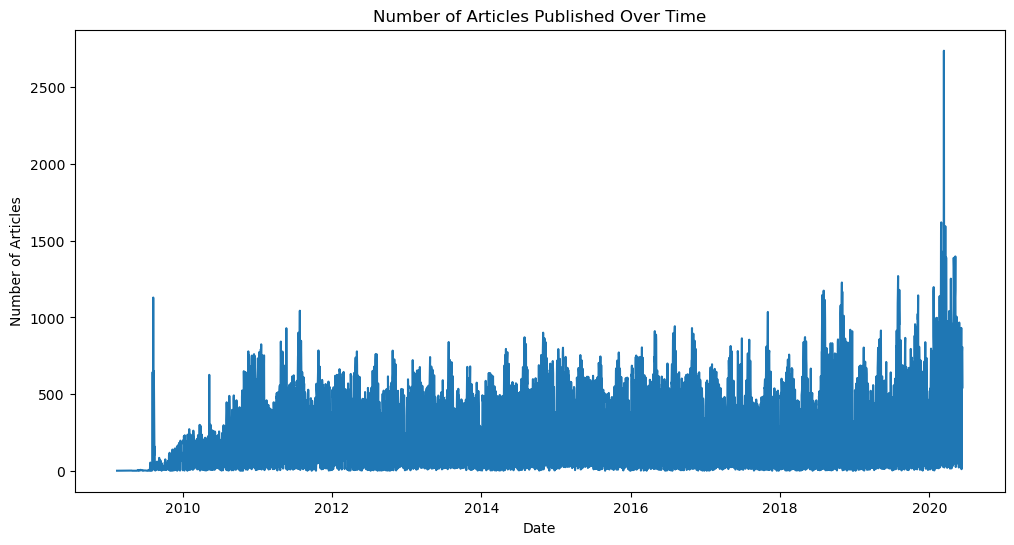

In [27]:
plt.figure(figsize=(12, 6))
daily_publication_trend.plot()
plt.title('Number of Articles Published Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.show()

In [28]:
print(data['date'].dtype)

object



Publication Date Analysis:
Earliest publication date: 2009-02-14 00:00:00+00:00
Latest publication date: 2020-06-11 00:00:00+00:00
Most common publication date: 2020-03-12 00:00:00+00:00


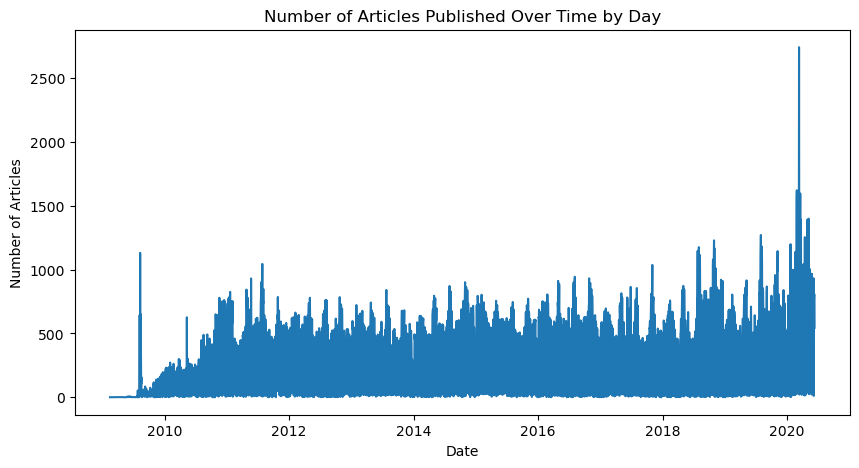

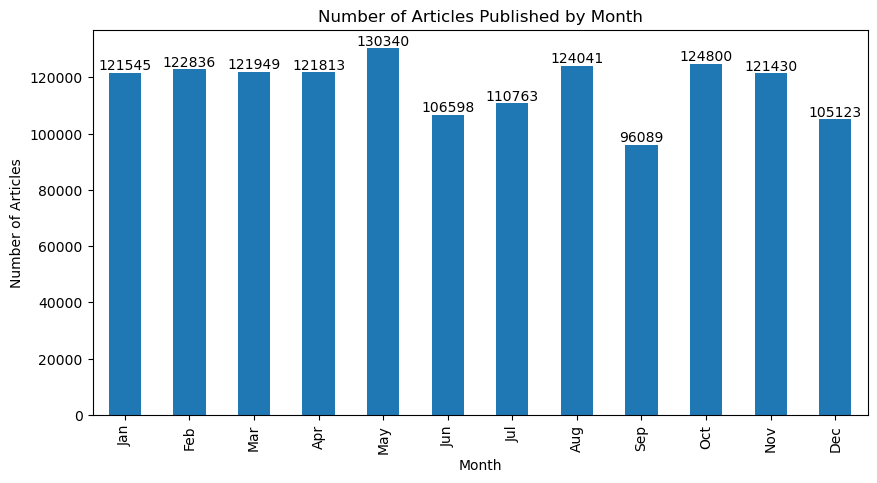

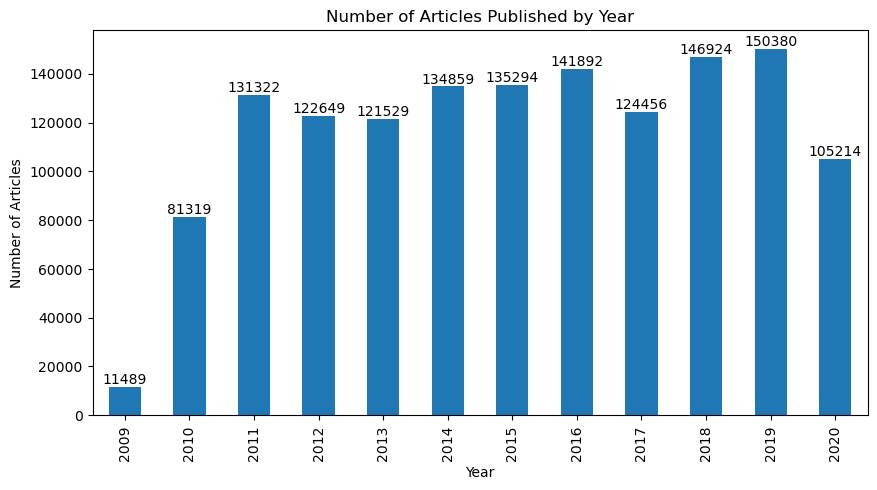

Most common date of publication: 2020-03-12 00:00:00+00:00
Most common month of publication: 5
Most common year of publication: 2019


In [29]:
# Extract date components
data['date'] = pd.to_datetime(data['date'], format='mixed', utc=True)
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
earliest_date = data['date'].min()
latest_date = data['date'].max()
most_common_date = data['date'].mode()[0]

print("\nPublication Date Analysis:")
print("Earliest publication date:", earliest_date)
print("Latest publication date:", latest_date)
print("Most common publication date:", most_common_date)

# Count of publications per day, month, and year
publications_per_day = data['date'].dt.date.value_counts().sort_index()
publications_per_month = data['month'].value_counts().sort_index()
publications_per_year = data['year'].value_counts().sort_index()

# Plot the number of articles published by day
plt.figure(figsize=(10, 5))
publications_per_day.plot(kind='line')
plt.title('Number of Articles Published Over Time by Day')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.show()

# Plot the number of articles published by month
plt.figure(figsize=(10, 5))
ax = publications_per_month.plot(kind='bar')
plt.title('Number of Articles Published by Month')
plt.xlabel('Month')
plt.ylabel('Number of Articles')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Add count values on top of each bar
for i in ax.containers:
    ax.bar_label(i)

plt.show()

# Plot the number of articles published by year
plt.figure(figsize=(10, 5))
ax = publications_per_year.plot(kind='bar')
plt.title('Number of Articles Published by Year')
plt.xlabel('Year')
plt.ylabel('Number of Articles')

# Add count values on top of each bar
for i in ax.containers:
    ax.bar_label(i)

plt.show()

# Display the most common date, month, and year of publication
most_common_month = publications_per_month.idxmax()
most_common_year = publications_per_year.idxmax()

print("Most common date of publication:", most_common_date)
print("Most common month of publication:", most_common_month)
print("Most common year of publication:", most_common_year)


In [30]:
#  Publisher Analysis

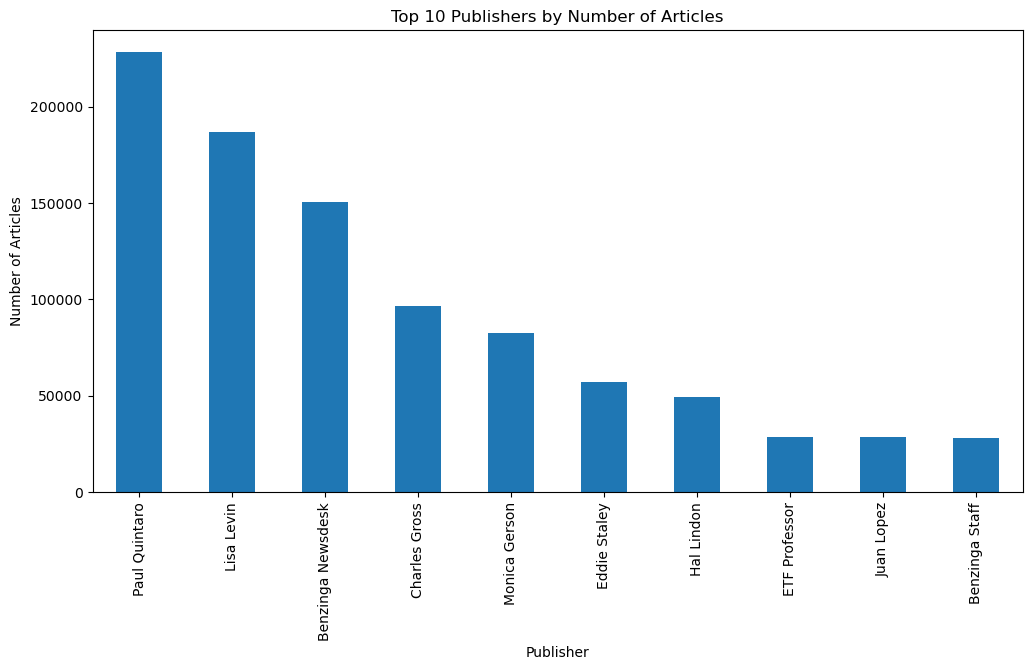

In [31]:
# a) Contribution by publishers
plt.figure(figsize=(12, 6))
publisher_activity.head(10).plot(kind='bar')
plt.title('Top 10 Publishers by Number of Articles')
plt.xlabel('Publisher')
plt.ylabel('Number of Articles')
plt.show()

In [32]:
# Unique Domains from Publisher Email
data['domain'] = data['publisher'].apply(lambda x: x.split('@')[-1] if '@' in x else 'other')
domain_distribution = data['domain'].value_counts()
print("\nDomain Distribution:\n", domain_distribution)


Domain Distribution:
 domain
other                     1399239
benzinga.com                 7937
gmail.com                     139
andyswan.com                    5
investdiva.com                  2
tothetick.com                   2
eosdetroit.io                   1
forextraininggroup.com          1
stockmetrix.net                 1
Name: count, dtype: int64


In [33]:
# a. Headline Length Analysis

In [34]:
data['headline_length'] = data['headline'].apply(len)
headline_length_stats = data['headline_length'].describe()
print("Headline Length Statistics:\n", headline_length_stats)

Headline Length Statistics:
 count    1.407327e+06
mean     7.312054e+01
std      4.073532e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


In [35]:
# b. Publisher Activity

In [36]:
publisher_activity = data['publisher'].value_counts()
print("\nPublisher Activity:\n", publisher_activity)


Publisher Activity:
 publisher
Paul Quintaro                      228373
Lisa Levin                         186978
Benzinga Newsdesk                  150484
Charles Gross                       96732
Monica Gerson                       82380
                                    ...  
Shazir Mucklai - Imperium Group         1
Laura Jennings                          1
Eric Martin                             1
Jose Rodrigo                            1
Jeremie Capron                          1
Name: count, Length: 1034, dtype: int64


In [37]:
# . Text Analysis (Sentiment Analysis & Topic Modeling)
# a) Sentiment analysis on headlines

In [38]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Belayneh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [39]:
# Calculate the sentiment of the headlines
data['sentiment_score'] = data['headline'].apply(lambda x: sia.polarity_scores(text=x)['compound'])

In [40]:
# Labeling the Sentiments
def label_sentiment(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

In [41]:
data['sentiment_label'] = data['sentiment_score'].apply(label_sentiment)

In [42]:
# Check the distribution of sentiment labels
sentiment_distribution = data['sentiment_label'].value_counts()
print("\nSentiment Distribution:")
print(sentiment_distribution)


Sentiment Distribution:
sentiment_label
Neutral     741200
Positive    441851
Negative    224276
Name: count, dtype: int64


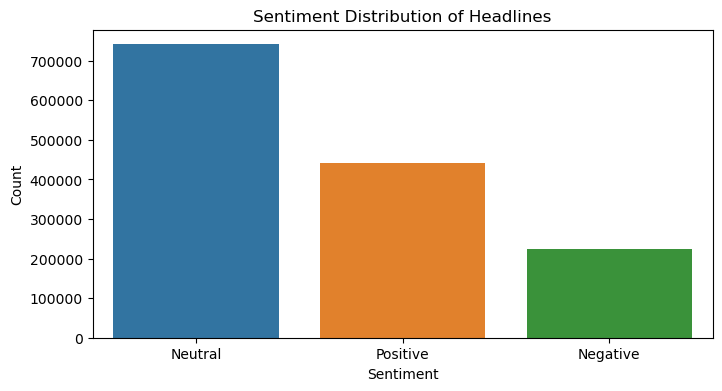

In [43]:
# Sentiment distribution plot
plt.figure(figsize=(8, 4))
sns.countplot(x='sentiment_label', data=data)
plt.title('Sentiment Distribution of Headlines')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [44]:
data.shape

(1407327, 13)

In [45]:
data.head()

,headline,url,publisher,date,stock,processed_headline,headline_length,year,month,day,domain,sentiment_score,sentiment_label
0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 00:00:00+00:00,A,stock hit high friday,39,2020,6,5,other,0.000,Neutral
1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 00:00:00+00:00,A,stock hit high wednesday,42,2020,6,3,other,0.000,Neutral
2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 00:00:00+00:00,A,biggest mover friday,29,2020,5,26,other,0.000,Neutral
3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 00:00:00+00:00,A,stock move friday session,44,2020,5,22,other,0.000,Neutral
4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 00:00:00+00:00,A,secur maintain neutral agil technolog rais pri...,87,2020,5,22,other,0.296,Positive


In [46]:
apple_data = data[data['stock'] == 'AAPL']
apple_data

,headline,url,publisher,date,stock,processed_headline,headline_length,year,month,day,domain,sentiment_score,sentiment_label
6680,Tech Stocks And FAANGS Strong Again To Start D...,https://www.benzinga.com/government/20/06/1622...,JJ Kinahan,2020-06-10 00:00:00+00:00,AAPL,tech stock faang strong start day market await...,69,2020,6,10,other,0.5574,Positive
6681,10 Biggest Price Target Changes For Wednesday,https://www.benzinga.com/analyst-ratings/price...,Lisa Levin,2020-06-10 00:00:00+00:00,AAPL,biggest price target chang wednesday,45,2020,6,10,other,0.0000,Neutral
6682,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",https://www.benzinga.com/short-sellers/20/06/1...,Benzinga Newsdesk,2020-06-10 00:00:00+00:00,AAPL,benzinga pro top stock watch jun aapl bac nio ...,87,2020,6,10,other,0.2023,Positive
6683,"Deutsche Bank Maintains Buy on Apple, Raises P...",https://www.benzinga.com/news/20/06/16219873/d...,Benzinga Newsdesk,2020-06-10 00:00:00+00:00,AAPL,deutsch bank maintain buy appl rais price target,65,2020,6,10,other,0.0000,Neutral
6684,Apple To Let Users Trade In Their Mac Computer...,https://www.benzinga.com/news/20/06/16218697/a...,Neer Varshney,2020-06-10 00:00:00+00:00,AAPL,appl let user trade mac comput credit canada s...,87,2020,6,10,other,0.3818,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7116,"UBS Maintains Buy on Apple, Lowers Price Targe...",https://www.benzinga.com/news/20/03/15514989/u...,Vick Meyer,2020-03-10 00:00:00+00:00,AAPL,ub maintain buy appl lower price target,55,2020,3,10,other,-0.1280,Negative
7117,123 Biggest Movers From Yesterday,https://www.benzinga.com/news/20/03/15514298/1...,Lisa Levin,2020-03-10 00:00:00+00:00,AAPL,biggest mover yesterday,33,2020,3,10,other,0.0000,Neutral
7118,Crude Awakening: Energy Sector Takes A 20% Spi...,https://www.benzinga.com/news/earnings/20/03/1...,JJ Kinahan,2020-03-09 00:00:00+00:00,AAPL,crude awaken energi sector take spill crude pr...,91,2020,3,9,other,-0.9062,Negative
7119,Investor Movement Index Summary: February 2020,https://www.benzinga.com/news/earnings/20/03/1...,TD Ameritrade,2020-03-09 00:00:00+00:00,AAPL,investor movement index summari februari,46,2020,3,9,other,0.0000,Neutral


In [47]:
apple_data['sentiment_label'].value_counts()

sentiment_label
Neutral     195
Positive    149
Negative     97
Name: count, dtype: int64

In [48]:
data.to_csv('D:/10 Academy/Week1/Data/labeled_and_processed_dataset.csv', index=False)

In [49]:
#  Time Series Analysis
# a) Publication frequency over time

In [50]:
Yearly_publication_trend = data['date'].dt.to_period("Y").value_counts().sort_index()

C:\Users\Belayneh\AppData\Local\Temp\ipykernel_5588\372510520.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  Yearly_publication_trend = data['date'].dt.to_period("Y").value_counts().sort_index()


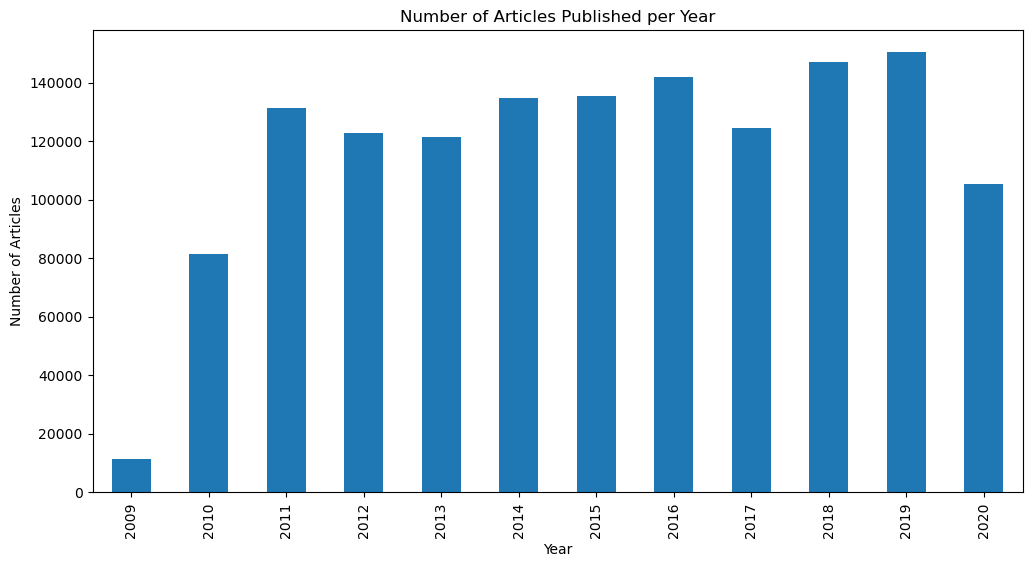

In [51]:
plt.figure(figsize=(12, 6))
Yearly_publication_trend.plot(kind='bar')
plt.title('Number of Articles Published per Year')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.show()

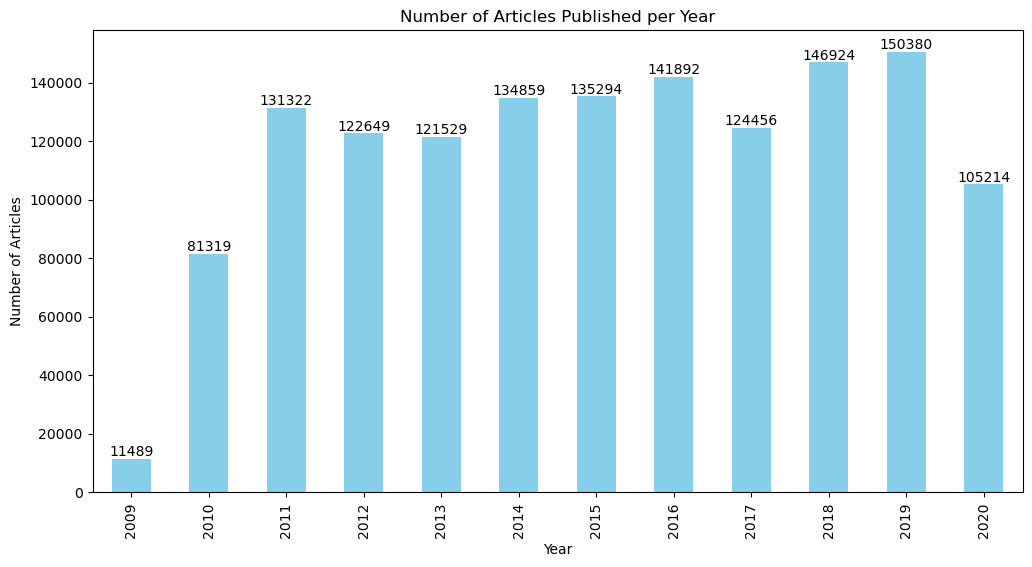

In [52]:
plt.figure(figsize=(12, 6))
ax = Yearly_publication_trend.plot(kind='bar', color='skyblue')
plt.title('Number of Articles Published per Year')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

plt.show()

In [53]:
publisher_sentiment_analysis = data.groupby('publisher')['sentiment_label'].value_counts()
print("\nPublisher Sentiment Analysis:\n", publisher_sentiment_analysis)


Publisher Sentiment Analysis:
 publisher       sentiment_label
47ertrends      Neutral               18
AARP            Neutral                7
ABNNewswire     Positive               5
                Negative               4
                Neutral                4
                                   ...  
wallstreet1928  Positive               1
                Negative               1
webmaster       Neutral            12305
                Positive            4591
                Negative            3417
Name: count, Length: 2212, dtype: int64


In [54]:
# b) Topic Modeling

In [55]:
# Preprocessing text data
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(data['processed_headline'])

In [56]:
# Applying LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

LatentDirichletAllocation(n_components=5, random_state=42)

In [57]:
n_top_words = 10
feature_names = vectorizer.get_feature_names_out()

In [58]:
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)
n_top_words = 10
feature_names = vectorizer.get_feature_names_out()

for index, topic in enumerate(lda.components_):
    print(f"\nTopic {index + 1}:")
    print([feature_names[i] for i in topic.argsort()[-n_top_words:]])


Topic 1:
['share', 'beat', 'revenu', 'updat', 'estim', 'market', 'sale', 'report', 'est', 'ep']

Topic 2:
['deal', 'offer', 'share', 'new', 'market', 'report', 'say', 'announc', 'session', 'stock']

Topic 3:
['week', 'alert', 'benzinga', 'trade', 'option', 'watch', 'schedul', 'stock', 'etf', 'earn']

Topic 4:
['hit', 'low', 'bank', 'high', 'price', 'maintain', 'buy', 'rais', 'target', 'stock']

Topic 5:
['higher', 'coverag', 'upgrad', 'announc', 'initi', 'benzinga', 'compani', 'downgrad', 'trade', 'share']


In [59]:
#Topic Distribution

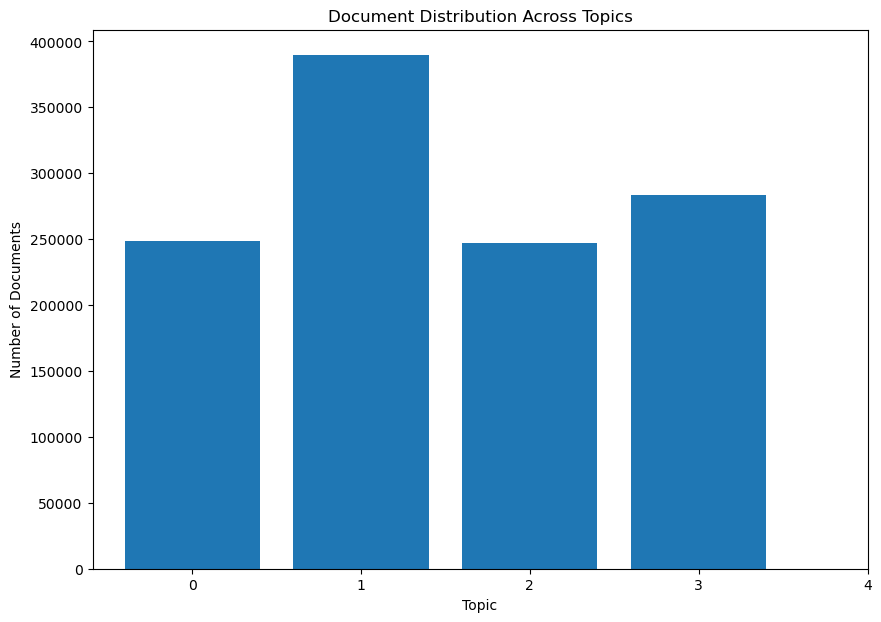

In [60]:
doc_topic_dist = lda.transform(X)
plt.figure(figsize=(10, 7))
plt.hist(np.argmax(doc_topic_dist, axis=1), bins=np.arange(lda.n_components) - 0.5, rwidth=0.8)
plt.xlabel('Topic')
plt.ylabel('Number of Documents')
plt.title('Document Distribution Across Topics')
plt.xticks(range(lda.n_components))
plt.show()

In [61]:
# 4. Time Series Analysis
# a) Publication frequency over time

C:\Users\Belayneh\AppData\Local\Temp\ipykernel_5588\2157811194.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_publication_trend = data['date'].dt.to_period("M").value_counts().sort_index()


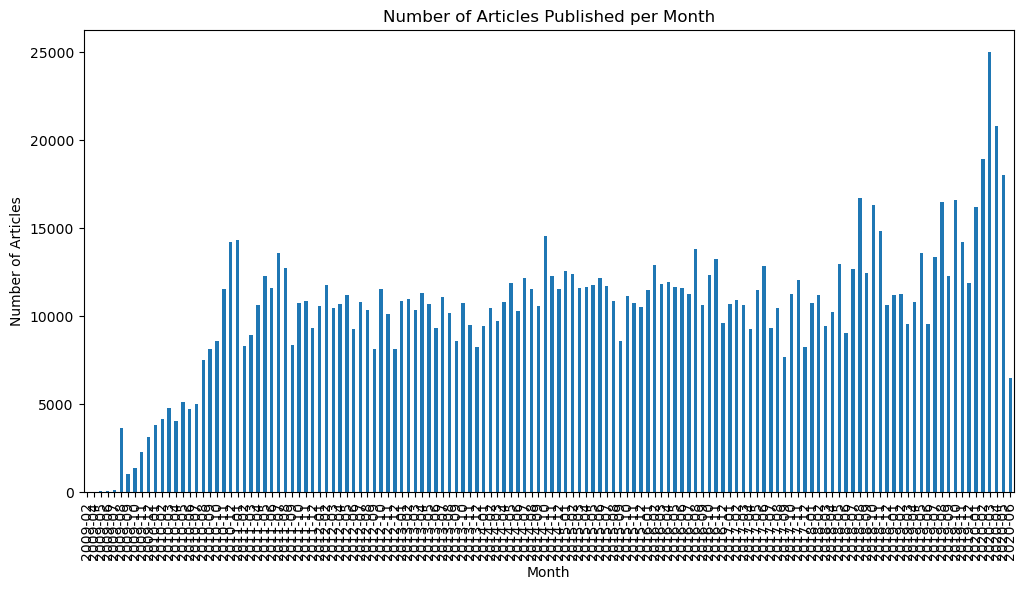

In [62]:
monthly_publication_trend = data['date'].dt.to_period("M").value_counts().sort_index()
plt.figure(figsize=(12, 6))
monthly_publication_trend.plot(kind='bar')
plt.title('Number of Articles Published per Month')
plt.xlabel('Month')
plt.ylabel('Number of Articles')
plt.show()

In [63]:
# b) Analysis of publishing times

In [64]:
data['time_of_day'] = data['date'].dt.hour
time_distribution = data['time_of_day'].value_counts().sort_index()

In [66]:
# 5. Publisher Analysis
# a) Contribution by publishers

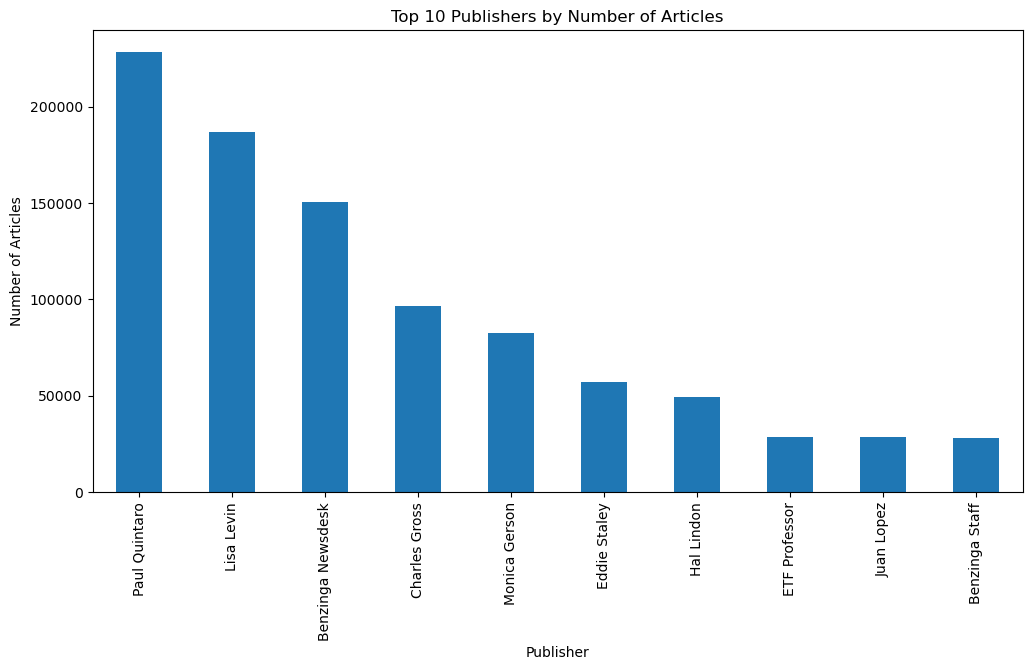

In [67]:
plt.figure(figsize=(12, 6))
publisher_activity.head(10).plot(kind='bar')
plt.title('Top 10 Publishers by Number of Articles')
plt.xlabel('Publisher')
plt.ylabel('Number of Articles')
plt.show()

In [68]:
# b) Unique domain analysis (if email addresses are used)

In [69]:
if data['publisher'].str.contains('@').any():
    data['domain'] = data['publisher'].apply(lambda x: x.split('@')[-1])
    domain_activity = data['domain'].value_counts()
    print("\nTop 10 Domains by Number of Articles:")
    print(domain_activity.head(10))


Top 10 Domains by Number of Articles:
domain
Paul Quintaro        228373
Lisa Levin           186978
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64


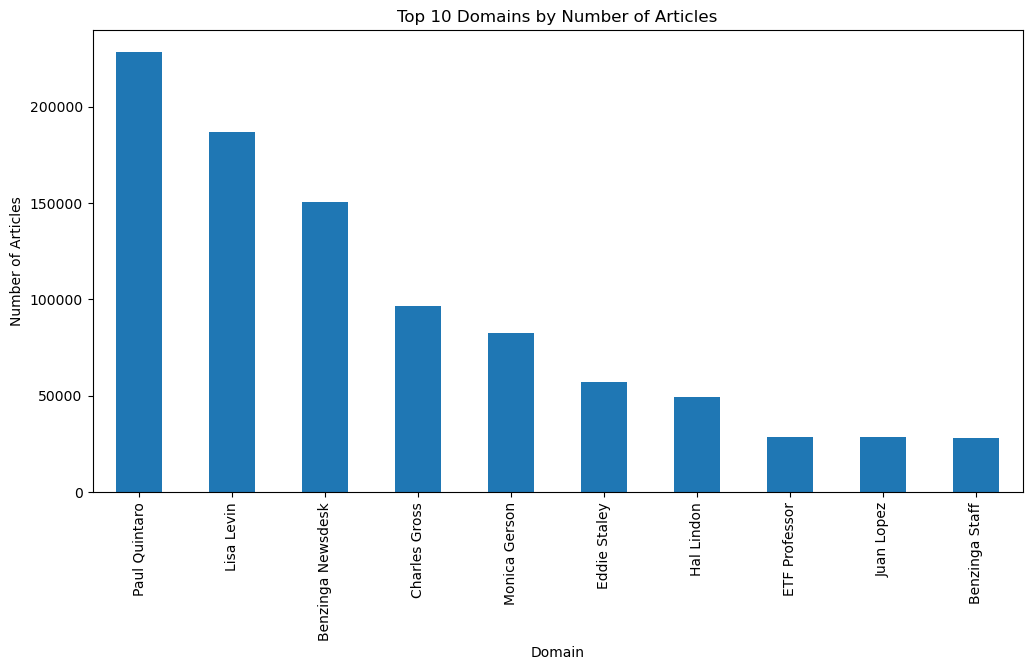

In [70]:
plt.figure(figsize=(12, 6))
domain_activity.head(10).plot(kind='bar')
plt.title('Top 10 Domains by Number of Articles')
plt.xlabel('Domain')
plt.ylabel('Number of Articles')
plt.show()